# Imports and overview

This notebook implements the DANN model from https://arxiv.org/abs/1505.07818. It is inspired from https://github.com/fungtion/DANN and https://github.com/Yangyangii/DANN-pytorch/blob/master/DANN.ipynb.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torchsummary
from tqdm import tqdm
import torchmetrics
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import sys
sys.path.append("../../Datasets/")
from Custom_Dataset import *

We can set the seed for all packages to ensure reproducibility.

In [2]:
torch.manual_seed(0)

For reference, here follows a diagram of the model from the paper:

<img src="Model diagram.png" align="center"/>

# Pre-processing

We start by defining a custom dataset which loads the data from disk lazily. This is because we have too many training examples to keep all of them in memory at once. The CustomDataset class is defined in Datasets/Cutsom_Dataset.py

In [3]:
# Extract the generated data
train_gen_dataset = CustomDataset("Generated", "train", balance = True)
val_gen_dataset = CustomDataset("Generated", "validation", balance=True)
test_gen_dataset = CustomDataset("Generated", "test", balance=True)

# Extract the real data
train_real_dataset = CustomDataset("Real Life", "train", balance=True)
val_real_dataset = CustomDataset("Real Life", "validation", balance=True)
test_real_dataset = CustomDataset("Real Life", "test", balance=True)

# Hyperparameter choices

It is now useful to include a cell that controls the hyperparameters of the model so that they are all grouped in a single location.

In [4]:
learning_rate_choices = {0.01, 0.0075} # 0.01 was suggested by paper
lambda_DA_choices = {0.1, 0.2, "variablepaper"}
gamma_DA = 10 # Suggested by paper
alpha_DA = 10 # Suggested by paper
beta_DA = 0.75 # Suggested by paper
batch_size = 100 # Each the real and generated data will be split into batches of this size / 2
num_epochs = 30 # Number of epochs to train for
n_loss = 10  # Print the loss every n_loss steps
gamma_focal_loss = 2 # Choices for the gamma parameter in the focal loss
n_validation = 10 # Number of iterations between each validation run
n_validation_minibatches = 2 # Number of minibatches to use for validation
n_final_validation_minibatches = 20 # Number of minibatches to use for the final validation run

To explain further, the learning rate is updated as follows:
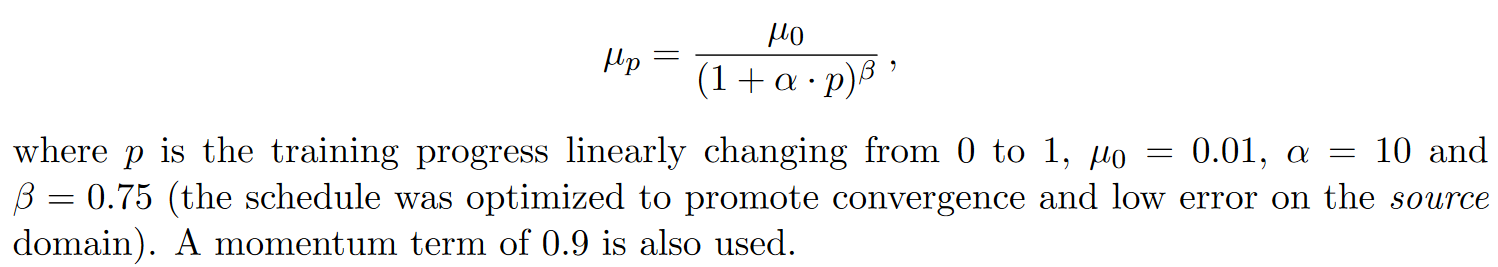

# Model implementation

We then proceed to check for the existence of a gpu to train faster.

In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.has_mps:
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

if DEVICE == "cuda":
    torch.cuda.empty_cache()

print("Device:", DEVICE)

Device: mps


We start by implementing the feature extractor portion of the DANN, using a pre-trained VGG16. To achieve that, we first visualize the VGG16 architecture.

In [6]:
model = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Furthermore, because input images are 100*100 with 3 channels, we use torchsummary to see what the output shape is:

In [7]:
torchsummary.summary(model, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           1,792
              ReLU-2         [-1, 64, 100, 100]               0
            Conv2d-3         [-1, 64, 100, 100]          36,928
              ReLU-4         [-1, 64, 100, 100]               0
         MaxPool2d-5           [-1, 64, 50, 50]               0
            Conv2d-6          [-1, 128, 50, 50]          73,856
              ReLU-7          [-1, 128, 50, 50]               0
            Conv2d-8          [-1, 128, 50, 50]         147,584
              ReLU-9          [-1, 128, 50, 50]               0
        MaxPool2d-10          [-1, 128, 25, 25]               0
           Conv2d-11          [-1, 256, 25, 25]         295,168
             ReLU-12          [-1, 256, 25, 25]               0
           Conv2d-13          [-1, 256, 25, 25]         590,080
             ReLU-14          [-1, 256,

The output shape is 512 * 3 * 3 = 4608 after flattening.

In [8]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        # Import the VGG16 model
        self.conv = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features

        # Freeze all the weights in modules 0 up-to and including 25
        for param in self.conv[:25].parameters():
            param.requires_grad = False

        
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return x

We then proceed to implement to Classifier portion of the model.

In [9]:
class Classifier(nn.Module):

    def __init__(self, input_size=4608, num_classes=13):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, h):
        c = self.layer(h)
        return c

Finally, we implement the discriminator, which starts with a custom gradient reversal layer.

In [10]:
class GradientReversal(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, lamb):
        ctx.lamb = lamb # Save the lambda DA hyperparameter to use during the backward pass
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lamb
        return output, None

class Discriminator(nn.Module):

    def __init__(self, input_size=4608, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, h, lamb):
        h = GradientReversal.apply(h, lamb)
        y = self.layer(h)
        return y

# Training

We now move on to defining our loss functions and metrics.

In [11]:
domain_loss = nn.BCEWithLogitsLoss(reduction="mean") # Binary Cross Entropy Loss with sigmoid
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=13, average="weighted").to(DEVICE)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

We also define the following function to plot the metrics:

In [12]:
def plot_and_save_metrics(gen_training_discriminator_losses, gen_training_classifier_losses, real_training_discriminator_losses, \
                           gen_training_accs, gen_training_f1s, gen_validation_discriminator_losses, gen_validation_classifier_losses, \
                              real_validation_discriminator_losses, real_validation_classifier_losses, gen_validation_accs, gen_validation_f1s, \
                                real_validation_accs, real_validation_f1s, lambda_DA, learning_rate):

    validation_x_axis = np.arange(0, len(gen_validation_discriminator_losses) * n_validation, n_validation)

    plt.figure(figsize=(40, 40))

    plt.subplot(4, 2, 1)
    plt.plot(gen_training_discriminator_losses)
    plt.title("Training Source Domain Classifier Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")

    plt.subplot(4, 2, 2)
    plt.plot(gen_training_classifier_losses, label="Source Domain")
    plt.plot(real_training_discriminator_losses, label="Target Domain")
    plt.title("Training Discriminator Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(4, 2, 3)
    plt.plot(gen_training_accs)
    plt.title("Training Source Domain Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")

    plt.subplot(4, 2, 4)
    plt.plot(gen_training_f1s)
    plt.title("Training Source Domain weighted F1 Scores")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted F1 Score")

    plt.subplot(4, 2, 5)
    plt.plot(validation_x_axis, gen_validation_discriminator_losses, label="Source Domain")
    plt.plot(validation_x_axis, real_validation_discriminator_losses, label="Target Domain")
    plt.title("Validation Discriminator Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(4, 2, 6)
    plt.plot(validation_x_axis, gen_validation_classifier_losses, label="Source Domain")
    plt.plot(validation_x_axis, real_validation_classifier_losses, label="Target Domain")
    plt.title("Validation Classifier Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(4, 2, 7)
    plt.plot(validation_x_axis, gen_validation_accs, label="Source Domain")
    plt.plot(validation_x_axis, real_validation_accs, label="Target Domain")
    plt.title("Validation Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(4, 2, 8)
    plt.plot(validation_x_axis, gen_validation_f1s, label="Source Domain")
    plt.plot(validation_x_axis, real_validation_f1s, label="Target Domain")
    plt.title("Validation weighted F1 Scores")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted F1 Score")
    plt.legend()

    plt.suptitle("Hyperparameters - Lambda: " + str(lambda_DA) + ", Learning rate: " + str(learning_rate), fontsize=24)
    
    plt.savefig("HP tuning results/" + "lambda_" + str(lambda_DA) + "_lr_" + str(learning_rate)  + ".png",  facecolor='white', transparent=False)
    plt.close()

We can now define a loop below. It is to be noted that the length of an epoch is defined by the number of real life training examples, not by the number of generated training examples, because we always try to keep our minibatches at a 50/50 split between real life and generated data.

In [13]:
# To store the best model
best_model_F = None
best_model_D = None
best_model_C = None
best_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Lambda (Domain adaptation)", "Learning Rate",  "Final validation accuracy"])

for lambda_DA in lambda_DA_choices: 

        for learning_rate in learning_rate_choices:

            # Define the data loaders accounting for the batch size
            gen_train_loader = get_gen_loader(train_gen_dataset, batch_size=batch_size // 2)
            gen_val_loader = get_gen_loader(val_gen_dataset, batch_size=batch_size // 2)
            gen_test_loader = get_gen_loader(test_gen_dataset, batch_size=batch_size // 2)
            real_train_loader = get_real_loader(train_real_dataset, batch_size=batch_size // 2)
            real_val_loader = get_real_loader(val_real_dataset, batch_size=batch_size // 2)
            real_test_loader = get_real_loader(test_real_dataset, batch_size=batch_size // 2)

            # Define the new loss function (Taking into account gamma)
            focal_loss = torch.hub.load(
                'adeelh/pytorch-multi-class-focal-loss',
                model='FocalLoss',
                gamma=gamma_focal_loss, # No use of alpha since we have balanced classes now with the oversampling
                reduction='mean',
                force_reload=False,
                verbose = False
            ).to(DEVICE)

            # To store the metrics through epochs
            gen_training_discriminator_losses = []
            gen_training_classifier_losses = []
            real_training_discriminator_losses = []
            gen_training_accs = []
            gen_training_f1s = []
            gen_validation_discriminator_losses = []
            gen_validation_classifier_losses = []
            real_validation_discriminator_losses = []
            real_validation_classifier_losses = []
            gen_validation_accs = []
            gen_validation_f1s = []
            real_validation_accs = []
            real_validation_f1s = []

            # Define the model and the optimizers
            F = FeatureExtractor().to(DEVICE)
            C = Classifier().to(DEVICE)
            D = Discriminator().to(DEVICE) 
            F_opt = torch.optim.SGD(F.parameters(), lr=learning_rate, momentum=0.9)
            C_opt = torch.optim.SGD(C.parameters(), lr=learning_rate, momentum=0.9)
            D_opt = torch.optim.SGD(D.parameters(), lr=learning_rate, momentum=0.9)
            
            for epoch in range(num_epochs):
                
                # Train the model
                for iteration, ((X_train_real, _), (X_train_gen, y_train_gen)) in tqdm(enumerate(zip(real_train_loader, gen_train_loader))):
                    
                    # Set the model to training mode
                    F.train()
                    C.train()
                    D.train()

                    # Move the data to the device
                    X_train_gen = X_train_gen.to(DEVICE)
                    y_train_gen = y_train_gen.to(DEVICE)
                    X_train_real = X_train_real.to(DEVICE)
                    
                    # Compute the domain adaptation factor lambda to be used in the forward pass
                    # Only done when the lambda is set to variablepaper
                    if lambda_DA == "variablepaper":
                        # Linear progress of the training (from 0 to 1)
                        p = epoch / num_epochs + iteration / len(real_train_loader) / num_epochs
                        # Compute the lambda
                        lamb = 2. / (1. + np.exp(-gamma_DA*p)) - 1
                    else:
                        lamb = lambda_DA # Just assign the value otherwise

                    # Generate the domain labels on the GPU directly (Zeros for real, ones for generated)
                    y_train_real_domain = torch.zeros(X_train_real.shape[0], 1).to(DEVICE)
                    y_train_gen_domain = torch.ones(X_train_gen.shape[0], 1).to(DEVICE)

                    # 1) Forward pass

                    # Extract the hidden representations of the real target examples
                    H = F(X_train_real)

                    # Predict the domain for the real target examples
                    y_real_raw_pred_domain= D(H, lamb)
                    y_real_pred_domain = torch.round(y_real_raw_pred_domain)

                    # Compute the loss for the real target examples
                    D_loss_train_real = domain_loss(y_real_raw_pred_domain, y_train_real_domain.float())

                    # Extract the hidden representations of the generated examples
                    H_generated = F(X_train_gen)

                    # Predict the domain & piece for the generated examples
                    y_gen_raw_domain = D(H_generated, lamb)
                    y_gen_pred_domain = torch.round(y_gen_raw_domain)
                    y_gen_raw_piece = C(H_generated)
                    y_gen_pred_piece = torch.argmax(y_gen_raw_piece, dim=1)

                    # Compute the losses
                    D_loss_train_gen = domain_loss(y_gen_raw_domain, y_train_gen_domain.float()) 
                    C_loss_train_gen = focal_loss(y_gen_raw_piece, y_train_gen)

                    # Compute the loss to be backpropagated (Works with the gradient trick)
                    backprop_loss = C_loss_train_gen + D_loss_train_real + D_loss_train_gen

                    # Compute the accuracies and f1 scores for both the generated and real target examples
                    gen_acc_train = accuracy(y_gen_pred_piece, y_train_gen)
                    gen_f1_train = f1_score(y_gen_pred_piece, y_train_gen)

                    # Store the loss & accuracy
                    gen_training_discriminator_losses.append(D_loss_train_gen.item())
                    gen_training_classifier_losses.append(C_loss_train_gen.item())
                    real_training_discriminator_losses.append(D_loss_train_real.item())
                    gen_training_accs.append(gen_acc_train.item())
                    gen_training_f1s.append(gen_f1_train.item())

                    # 2) Backward pass
                    F.zero_grad()
                    C.zero_grad()
                    D.zero_grad()
                    backprop_loss.backward()
                    F_opt.step()
                    C_opt.step()
                    D_opt.step()

                    # Check if the model should be validated
                    if iteration == 0 or (iteration + 1) % n_validation == 0:
                        
                        # Set the model to evaluation mode
                        F.eval()
                        C.eval()
                        D.eval()
                        
                        # Disable gradient calculation
                        with torch.no_grad():

                            # 1) Evaluate on the generated validation set
                            acc_val_sum = 0
                            weighted_f1_val_sum = 0
                            D_loss_val_sum = 0
                            C_loss_val_sum = 0

                            # Extract an iterator from the generated data loader
                            gen_val_iter = iter(gen_val_loader)

                            # Iterate for n_validation_minibatches
                            for i in range(n_validation_minibatches):

                                # Get the next minibatch
                                minibatch = next(gen_val_iter, None)
                                if minibatch is None:
                                    gen_val_iter = iter(gen_val_loader)
                                    minibatch = next(gen_val_iter)

                                # Extract the data
                                X_val_gen, y_val_gen = minibatch
                                    
                                # Move the data to the device
                                X_val_gen = X_val_gen.to(DEVICE)
                                y_val_gen = y_val_gen.to(DEVICE)

                                # Forward pass
                                H = F(X_val_gen)
                                y_val_gen_raw_piece = C(H)
                                y_val_gen_pred_piece = torch.argmax(y_val_gen_raw_piece, dim=1)
                                y_val_gen_raw_domain = D(H, lamb)
                                y_val_gen_pred_domain = torch.round(y_val_gen_raw_domain)

                                # Compute the metrics
                                acc_val_sum += accuracy(y_val_gen_pred_piece, y_val_gen)
                                weighted_f1_val_sum += f1_score(y_val_gen_pred_piece, y_val_gen)
                                D_loss_val_sum += domain_loss(y_val_gen_raw_domain, y_train_gen_domain.float())
                                C_loss_val_sum += focal_loss(y_val_gen_raw_piece, y_val_gen)


                            # Compute the average metrics
                            acc_val_gen = acc_val_sum / n_validation_minibatches
                            weighted_f1_val_gen = weighted_f1_val_sum / n_validation_minibatches
                            D_loss_val_gen = D_loss_val_sum / n_validation_minibatches
                            C_loss_val_gen = C_loss_val_sum / n_validation_minibatches

                            # 2) Repeat on the real validation set (Losses are accumulated)
                            acc_val_sum = 0
                            weighted_f1_val_sum = 0
                            D_loss_val_sum = 0
                            C_loss_val_sum = 0

                            # Extract an iterator from the generated data loader
                            real_val_iter = iter(real_val_loader)

                            # Iterate for n_validation_minibatches
                            for i in range(n_validation_minibatches):

                                # Get the next minibatch
                                minibatch = next(real_val_iter, None)
                                if minibatch is None:
                                    real_val_iter = iter(real_val_loader)
                                    minibatch = next(real_val_iter)

                                # Extract the data
                                X_val_real, y_val_real = minibatch

                                # Move the data to the device
                                X_val_real = X_val_real.to(DEVICE)
                                y_val_real = y_val_real.to(DEVICE)

                                # Forward pass
                                H = F(X_val_real)
                                y_val_real_raw_piece = C(H)
                                y_val_real_pred_piece = torch.argmax(y_val_real_raw_piece, dim=1)
                                y_val_real_raw_domain = D(H, lamb)
                                y_val_real_pred_domain = torch.round(y_val_real_raw_domain)

                                # Compute the metrics
                                acc_val_sum += accuracy(y_val_real_pred_piece, y_val_real)
                                weighted_f1_val_sum += f1_score(y_val_real_pred_piece, y_val_real)
                                D_loss_val_sum += domain_loss(y_val_real_raw_domain, y_train_real_domain.float())
                                C_loss_val_sum += focal_loss(y_val_real_raw_piece, y_val_real)

                            # Compute the average metrics
                            acc_val_real = acc_val_sum / n_validation_minibatches
                            weighted_f1_val_real = weighted_f1_val_sum / n_validation_minibatches
                            D_loss_val_real = D_loss_val_sum / n_validation_minibatches
                            C_loss_val_real = C_loss_val_sum / n_validation_minibatches

                            # Store all 8 metrics
                            real_validation_discriminator_losses.append(D_loss_val_real.item())
                            real_validation_classifier_losses.append(C_loss_val_real.item())
                            real_validation_accs.append(acc_val_real.item())
                            real_validation_f1s.append(weighted_f1_val_real.item())
                            gen_validation_discriminator_losses.append(D_loss_val_gen.item())
                            gen_validation_classifier_losses.append(C_loss_val_gen.item())
                            gen_validation_accs.append(acc_val_gen.item())
                            gen_validation_f1s.append(weighted_f1_val_gen.item())

                            # Print an update
                            clear_output(wait=True) # Only show the last print statement
                            print('----------------------------------------------------------------')
                            print(f'EPOCH [{epoch + 1}], ITERATION [{iteration+1}]')
                            print(f'TRAINING => C_loss_gen: {C_loss_train_gen}, D_loss_gen: {D_loss_train_gen}, D_loss_real: {D_loss_train_real}, Training accuracy gen: {gen_acc_train}, Training weighted F1 gen: {gen_f1_train}')
                            print(f'VALIDATION GEN=> C_loss_gen: {C_loss_val_gen}, D_loss_gen: {D_loss_val_gen}, Validation accuracy gen: {acc_val_gen}, Validation weighted F1 gen: {weighted_f1_val_gen}')
                            print(f'VALIDATION REAL=> C_loss_real: {C_loss_val_real}, D_loss_real: {D_loss_val_real}, Validation accuracy real: {acc_val_real}, Validation weighted F1 real: {weighted_f1_val_real}')
                            print('----------------------------------------------------------------')

                # Save the final version of every model as a checkpoint
                torch.save(F.state_dict(), f'./checkpoints/F_lambda_{lambda_DA}_lr_{learning_rate}.ckpt')
                torch.save(C.state_dict(), f'./checkpoints/C_lambda_{lambda_DA}_lr_{learning_rate}.ckpt')
                torch.save(D.state_dict(), f'./checkpoints/D_lambda_{lambda_DA}_lr_{learning_rate}.ckpt')


            # Evaluate the final real life validation accuracy

            # Set the model to evaluation mode
            F.eval()
            C.eval()
            D.eval()

            acc_val_sum = 0

            # Create an iterator
            real_val_iter = iter(real_val_loader)

            # Disable gradient calculation
            with torch.no_grad():
                
                for i in range(n_final_validation_minibatches):

                    # Get the next minibatch
                    minibatch = next(real_val_iter, None)
                    if minibatch is None:
                        real_val_iter = iter(real_val_loader)
                        minibatch = next(real_val_iter, None)
                    X_val_real, y_val_real = minibatch

                    # Move the data to the device
                    X_val_real = X_val_real.to(DEVICE)
                    y_val_real = y_val_real.to(DEVICE)

                    # Forward pass
                    H = F(X_val_real)
                    y_val_raw_piece_real = C(H)
                    y_val_pred_piece_real = torch.argmax(y_val_raw_piece_real, dim=1)

                    # Compute the metrics
                    acc_val_sum += accuracy(y_val_pred_piece_real, y_val_real)

            # Compute the average accuracy
            final_real_val_acc = acc_val_sum / n_final_validation_minibatches

            # Create a row to add to the dataframe
            row = [lambda_DA, learning_rate, final_real_val_acc.cpu().item()]

            # Store it
            hp_final_accs.loc[len(hp_final_accs)] = row

            # Compare to the best model
            if best_model_F is None or best_acc < final_real_val_acc:
                best_model_F = F
                best_model_C = C
                best_model_D = D
                best_acc = final_real_val_acc
                torch.save(F.state_dict(), f'./best_model_F.ckpt')
                torch.save(C.state_dict(), f'./best_model_C.ckpt')
                torch.save(D.state_dict(), f'./best_model_D.ckpt')

            # Plot and save the metrics
            plot_and_save_metrics(gen_training_discriminator_losses, gen_training_classifier_losses, real_training_discriminator_losses, gen_training_accs, gen_training_f1s, gen_validation_discriminator_losses, gen_validation_classifier_losses, real_validation_discriminator_losses, real_validation_classifier_losses, gen_validation_accs, gen_validation_f1s, real_validation_accs, real_validation_f1s, lambda_DA, learning_rate)

# Save the dataframe as a table
hp_final_accs.to_csv('HP_final_accuracies.csv', index=False)


80it [00:29,  2.72it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => C_loss_gen: 0.31474849581718445, D_loss_gen: 0.08858349919319153, D_loss_real: 0.9174376726150513, Training accuracy gen: 0.6599999666213989, Training weighted F1 gen: 0.6235642433166504
VALIDATION GEN=> C_loss_gen: 0.4911378026008606, D_loss_gen: 0.19010215997695923, Validation accuracy gen: 0.6800000071525574, Validation weighted F1 gen: 0.6347039937973022
VALIDATION REAL=> C_loss_real: 2.0427680015563965, D_loss_real: 0.687299907207489, Validation accuracy real: 0.3199999928474426, Validation weighted F1 real: 0.2602476179599762
----------------------------------------------------------------


86it [00:30,  2.79it/s]


KeyboardInterrupt: 